In [1]:
from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain_community.document_loaders import PyPDFLoader
import yaml
from pathlib import Path
import os
import re
import matplotlib.pyplot as plt
from typing import Annotated, Sequence, TypedDict, Dict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.tools import tool
from transformers import pipeline
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

/home/mohbakr/Documents/enviroments/pytolib/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-10 20:52:18.381141: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-10 20:52:18.381141: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
CURRENT_DIR = Path.cwd()
PARENT_DIR = CURRENT_DIR.parent

# Load config
with open(PARENT_DIR / "config" / "config.yaml", "r") as file:
    config = yaml.safe_load(file)

api_key = config["GROQ_API_KEY"]
embedding_model_name = config["EMBEDDING_MODEL"]

# Initialize LLM - Using a standard Groq model ID
llm = ChatGroq(
    api_key=api_key, 
    model="llama-3.3-70b-versatile", 
    temperature=0
)

embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name)

In [3]:
pdf_path = "../reports/_10-K-2025-As-Filed.pdf"
loader = PyPDFLoader(pdf_path).load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
texts = text_splitter.split_documents(loader)

# Fixed typo: vectoerDB -> vector_db
vector_db = Chroma.from_documents(texts, embeddings)
retriever = vector_db.as_retriever(search_type="similarity", search_kwargs={"k": 3})

In [4]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    question: str
    documents: str

summarization_pipeline = pipeline(
    "summarization",
    model="sshleifer/distilbart-cnn-12-6",
    device=0 # Set to -1 if you don't have a GPU
)

@tool
def summarize_tool(text: str) -> str:
    """Summarizes the input text into a concise and easy-to-read summary."""
    input_len = len(text.split())
    max_len = min(150, max(30, input_len))
    summary = summarization_pipeline(text, max_length=max_len, min_length=30, do_sample=False)
    return summary[0]["summary_text"]

@tool
def generate_and_run_chart(text_segment: str) -> str:
    """
    Generates financial charts from text and saves the PNG file 
    with a name corresponding to the chart's title.
    """
    os.makedirs("charts", exist_ok=True)
    
    # Updated prompt to specifically ask for a dynamic filename based on content
    prompt = (
        f"Based on this data: {text_segment}, generate Python matplotlib code to create a professional bar chart. "
        f"1. Determine a short, descriptive filename based on the chart title (e.g., 'revenue_trends.png'). "
        f"2. Save the chart using plt.savefig(os.path.join('charts', filename)). "
        f"3. Return ONLY the python code."
    )
    
    llm_response = llm.invoke([HumanMessage(content=prompt)])
    # Clean the response to get raw code
    code = re.sub(r"```(?:python)?", "", llm_response.content, flags=re.IGNORECASE).strip()

    try:
        # We pass os and plt into the exec globals so the generated code can use them
        exec_globals = {"plt": plt, "os": os}
        exec(code, exec_globals)
        
        # Optionally, try to find what filename the LLM chose to return a better confirmation
        return "Chart generated and saved successfully in the 'charts/' directory."
    except Exception as e:
        return f"Error executing chart code: {e}"

tools = [generate_and_run_chart, summarize_tool]
router_llm = llm.bind_tools(tools)

Device set to use cuda:0


In [5]:
def transform_query(state: AgentState):
    prompt = PromptTemplate(
        input_variables=["question"],
        template="Rewrite this user question to be search-engine friendly: {question}. Output only the query."
    )
    chain = prompt | llm | StrOutputParser()
    transformed_query = chain.invoke({"question": state['question']})
    return {"question": transformed_query}

def retriever_node(state: AgentState):
    docs = retriever.invoke(state["question"])
    combined_text = " ".join([doc.page_content for doc in docs])
    return {"documents": combined_text}

In [6]:
def transform_query(state: AgentState):
    prompt = PromptTemplate(
        input_variables=["question"],
        template="""
You are a query optimization assistant for an information retrieval system.

Your task is to rewrite the user's question into a clear, concise, and retrieval-friendly search query.

Rules:
- Preserve the original intent and meaning.
- Remove unnecessary words, filler phrases, or conversational tone.
- Expand acronyms or ambiguous terms when helpful.
- If the question is vague, infer the most likely information need.
- Do NOT answer the question.
- Do NOT add explanations.
- Output only the transformed query as a single sentence or short phrase.

User question:
{question}
"""
    )
    chain = prompt | llm | StrOutputParser()
    transformed_query = chain.invoke({"question": state['question']})
    return {"question": transformed_query}

def retriever_node(state: AgentState):
    docs = retriever.invoke(state["question"])
    combined_text = " ".join([doc.page_content for doc in docs])
    return {"documents": combined_text}


def reasoner(state: AgentState):
    print("---REASONER---")
    context = state.get("documents", "")
    question = state.get("question", "")
    
    # Define a system message to guide the LLM
    system_msg = (
        "You are a financial analyst. Use the provided context to answer the user. "
        "If you see a summary from a tool in the history, use it to give a final answer. "
        "Do not call a tool if the information is already present in the messages."
    )
    
    # Construct the message list including the history
    input_content = f"Context: {context}\n\nQuestion: {question}"
    messages = [
        HumanMessage(content=f"{system_msg}\n\n{input_content}")
    ] + list(state.get("messages", [])) # Include previous tool outputs
    
    response = router_llm.invoke(messages)
    
    # Return only the NEW response to be appended to state
    return {"messages": [response]}

def check_next(state):
    messages = state.get("messages", [])
    if not messages:
        return END

    last_message = messages[-1]
    
    # If the LLM didn't return tool_calls, it has provided a final answer
    if not hasattr(last_message, "tool_calls") or not last_message.tool_calls:
        return END

    # Route to the tools node
    return "tools"

--- Node: transform_query ---


--- Node: retriever ---


---REASONER---
--- Node: reasoner ---
Tool Calls: ['generate_and_run_chart']


--- Node: reasoner ---
Tool Calls: ['generate_and_run_chart']




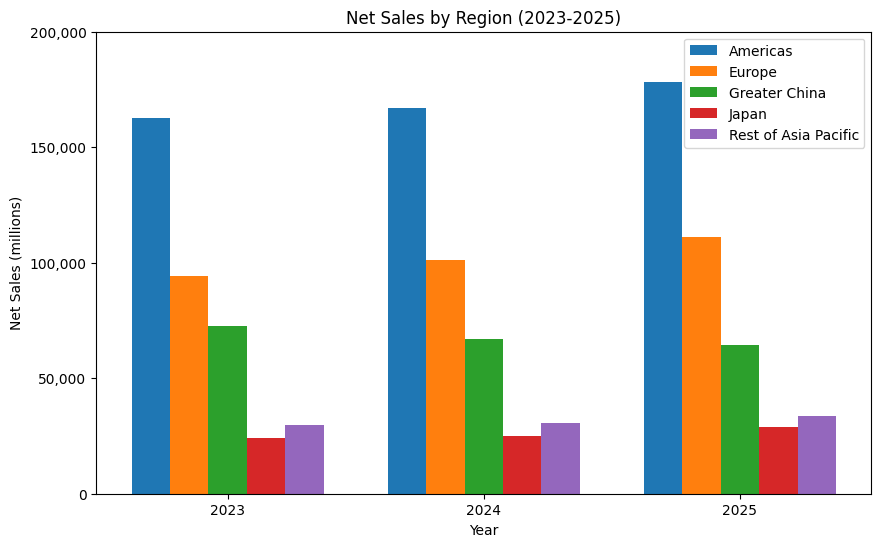

--- Node: tools ---
Chart generated and saved successfully in the 'charts/' directory.


---REASONER---
--- Node: reasoner ---
The graph illustrating Segment Operating Performance has been created based on the provided PDF data. The graph shows the net sales by reportable segment for 2025, 2024, and 2023.


--- Node: reasoner ---
The graph illustrating Segment Operating Performance has been created based on the provided PDF data. The graph shows the net sales by reportable segment for 2025, 2024, and 2023.




In [11]:
workflow = StateGraph(AgentState)

workflow.add_node("transform_query", transform_query)
workflow.add_node("retriever", retriever_node)
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "transform_query")
workflow.add_edge("transform_query", "retriever")
workflow.add_edge("retriever", "reasoner")

workflow.add_conditional_edges("reasoner", check_next, {"tools": "tools", END: END})
workflow.add_edge("tools", "reasoner")

app = workflow.compile()

# Test Run
inputs = {"question":"""accroding to the pdf  draw the graph for Segment Operating Performance """, "messages": []}

for output in app.stream(inputs):
    for key, value in output.items():
        print(f"--- Node: {key} ---")
        if "messages" in value:
            # Print the text content of the latest message
            msg = value["messages"][-1]
            if msg.content:
                print(msg.content)
            if hasattr(msg, 'tool_calls') and msg.tool_calls:
                print(f"Tool Calls: {[t['name'] for t in msg.tool_calls]}")
    print("\n")

In [10]:
result = app.invoke(inputs)
print("--- FINAL SUMMARY ---")
print(result["messages"][-1].content)

---REASONER---


Your max_length is set to 30, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


---REASONER---
---REASONER---
---REASONER---
--- FINAL SUMMARY ---
The US imposed tariffs and trade measures on imports from China, India, Japan, South Korea, Taiwan, Vietnam, and the EU, starting in the second quarter of 2025. In response, several countries imposed reciprocal tariffs on the US and other retaliatory measures.
--- FINAL SUMMARY ---
The US imposed tariffs and trade measures on imports from China, India, Japan, South Korea, Taiwan, Vietnam, and the EU, starting in the second quarter of 2025. In response, several countries imposed reciprocal tariffs on the US and other retaliatory measures.
